About Clustering:

Clustering is an unsupervised learning technique, in short, you are working on data, without having any information about a target attribute or a dependent variable. The general idea of clustering is to find some intrinsic structure in the data, often referred to as groups of similar objects. The algorithm studies the data to identify these patterns or groups such that each member in a group is closer to another member in the group (lower intracluster distance) and farther from another member in a different group (higher inter-cluster distance).

Where clustering fits in?

Most of you must be familiar with these examples from real life:

    Customer Segmentation — Used widely for targeted marketing
    Image Segmentation — Identify the change in landscape or intrusion
    Recommendation Engines

Background:

K Means clustering, irrespective of the platform uses a similarity measure in the form of Euclidean Distance. Often referred to as Divisive or Partitional Clustering, the basic idea of K Means is to start with every data point a bigger cluster and then divide them into smaller groups based on user input K (or the number of clusters). Each cluster has a center called the centroid. 

The total number of centroids in a given cluster is always equal to K. The algorithm iteratively looks for data points and assign them to their closest cluster.


Once all data points are assigned to their respective centroids (which represents each cluster here), the centroid values are recalculated and the process repeats until the clusters reach a convergence criterion. Centroids are nothing but new mean for each cluster 

(e.g. A Cluster Consisting of Customers A, B, C with an average spend of 100, 200, 300 and a basket size of 10, 15, and 20 will have centroids as 200 and 15 respectively). 

Convergence criterion is a measure of stability or compactness of the cluster, i.e. the intracluster distance between any two iterations doesn’t change beyond a given threshold.

Data:

The dataset consists of 9K active credit cardholders over 6 months and their transaction and account attributes. The idea is to develop a customer segmentation for marketing strategy.

In [1]:
from pyspark.sql import SparkSession
import gc

spark = SparkSession.builder.appName('KMeans Clustering').getOrCreate()

data_customer = spark.read.csv('CCGENERAL.csv', header=True, inferSchema=True)

data_customer.printSchema()

22/04/25 00:21:18 WARN Utils: Your hostname, sp-pc resolves to a loopback address: 127.0.1.1; using 172.29.34.215 instead (on interface eth0)
22/04/25 00:21:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/25 00:21:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/04/25 00:21:20 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


root
 |-- CUST_ID: string (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- BALANCE_FREQUENCY: double (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ONEOFF_PURCHASES: double (nullable = true)
 |-- INSTALLMENTS_PURCHASES: double (nullable = true)
 |-- CASH_ADVANCE: double (nullable = true)
 |-- PURCHASES_FREQUENCY: double (nullable = true)
 |-- ONEOFF_PURCHASES_FREQUENCY: double (nullable = true)
 |-- PURCHASES_INSTALLMENTS_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_FREQUENCY: double (nullable = true)
 |-- CASH_ADVANCE_TRX: integer (nullable = true)
 |-- PURCHASES_TRX: integer (nullable = true)
 |-- CREDIT_LIMIT: double (nullable = true)
 |-- PAYMENTS: double (nullable = true)
 |-- MINIMUM_PAYMENTS: double (nullable = true)
 |-- PRC_FULL_PAYMENT: double (nullable = true)
 |-- TENURE: integer (nullable = true)



The attributes that are self intuitive can be divided into three broader categories. 

    Customer Information (Primary Key as CUST_ID), 
    account information (balance, balance frequency, purchases, credit limit, tenure, etc.),
    and transactions (purchase frequency, payments, cash advance, etc.).

In [2]:
data_customer = data_customer.na.fill(0)

In [3]:
data_customer.show(1)

+-------+---------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+----------+----------------+----------------+------+
|CUST_ID|  BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|  PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|
+-------+---------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+----------+----------------+----------------+------+
| C10001|40.900749|         0.818182|     95.4|             0.0|                  95.4|         0.0|

All attributes under consideration are numerical or discrete numeric, hence we need to convert them into features using a Vector Assembler. A vector assembler is a transformer that converts a set of features into a single vector column often referred to as an array of features. Features here are columns. Since customer id is an identifier that won’t be used for clustering, we first extract the required columns using .columns, pass it as an input to Vector Assembler, and then use the transform() to convert the input columns into a single vector column called a feature.

In [4]:
from pyspark.ml.feature import VectorAssembler


['CUST_ID',
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE']

In [5]:
assemble = VectorAssembler(inputCols=[
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE'], outputCol='features')

In [6]:
assembled_data = assemble.transform(data_customer)
assembled_data.show(2)

22/04/25 00:21:24 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+
| C10001|  40.900749|       

Now that all columns are transformed into a single feature vector we need to standardize the data to bring them to a comparable scale. E.g. Balance can have a scale from 10–1000 whereas balance frequency has a scale from 0–1 say. Euclidean distance is always impacted more by variables on a higher scale, hence it’s important to scale the variables out.

In [7]:
from pyspark.ml.feature import StandardScaler

scale = StandardScaler(inputCol='features', outputCol='standardized')

data_scale=scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)

data_scale_output.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------------------+--------------------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|            features|        standardized|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+--------

Now that our data is standardized we can develop the K Means algorithm.

K-means is one of the most commonly used clustering algorithms for grouping data into a predefined number of clusters. The spark.mllib includes a parallelized variant of the k-means++ method called kmeans||. The KMeans function from pyspark.ml.clustering includes the following parameters:

    k is the number of clusters specified by the user
    
    maxIterations is the maximum number of iterations before the clustering algorithm stops. Note that if the intracluster distance doesn’t change beyond the epsilon value mentioned, the iteration will stop irrespective of max iterations
    
    initializationMode specifies either random initialization of centroids or initialization via k-means|| (similar to K-means ++)
    
    epsilon determines the distance threshold within which k-means is expected to converge
    
    initialModel is an optional set of cluster centroids that the user can provide as an input. If this parameter is used, the algorithm just runs once to allocate points to its nearest centroid

train(k=4, maxIterations=20, minDivisibleClusterSize=1.0, seed=-1888008604) are the default values.

In [8]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = {}

evaluator = ClusteringEvaluator(predictionCol='prediction',
                               featuresCol='standardized',
                               metricName='silhouette',
                               distanceMeasure='squaredEuclidean')


for i in range(2, 10):
    KMeans_algo = KMeans(featuresCol='standardized', k=i)
    KMeans_fit = KMeans_algo.fit(data_scale_output)
    output = KMeans_fit.transform(data_scale_output)
    
    score = evaluator.evaluate(output)
    silhouette_score[str(i)]=score
    print(f'silhouette_score {score} for no of clusters {i}')

silhouette_score 0.3008690254631598 for no of clusters 2
silhouette_score 0.26991484851164343 for no of clusters 3
silhouette_score 0.2824958884580647 for no of clusters 4
silhouette_score 0.3100414419963152 for no of clusters 5
silhouette_score 0.28173710618436026 for no of clusters 6
silhouette_score 0.26733546276980363 for no of clusters 7
silhouette_score 0.2968372729710698 for no of clusters 8
silhouette_score 0.30405580278105937 for no of clusters 9


Visualizing the silhouette score. Note previous versions of the K Means had computeScore() that calculated the sum of intracluster distance but got deprecated in Spark 3.0.0. Silhouette Score using ClusteringEvaluator() measures how close each point in one cluster is to points in the neighboring clusters thus helping in figuring out clusters that are compact and well-spaced out.

In [9]:
silhouette_score

{'2': 0.3008690254631598,
 '3': 0.26991484851164343,
 '4': 0.2824958884580647,
 '5': 0.3100414419963152,
 '6': 0.28173710618436026,
 '7': 0.26733546276980363,
 '8': 0.2968372729710698,
 '9': 0.30405580278105937}

In [10]:
k = int(max(silhouette_score, key=silhouette_score.get))
k

5

Text(0, 0.5, 'cost')

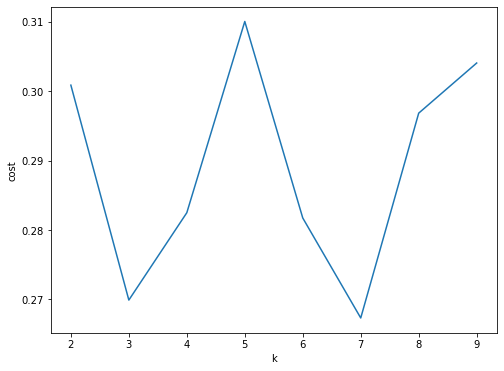

In [11]:
#Visualizing the silhouette scores in a plot

import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize =(8,6))

ax.plot(range(2,10), silhouette_score.values())
ax.set_xlabel('k')
ax.set_ylabel('cost')

The range of the Silhouette value is between +1 and -1. A high value is desirable and indicates that the point is placed in the correct cluster. If many points have a negative Silhouette value, it may indicate that we have created too many or too few clusters.

I prefer going ahead with K=3/5 where a local maxima of Silhouette Score is observed. Since there is no correct answer for what value of K is good, we can restore to descriptive statistics and plots to check the distribution of customers. This is where SkLearn comes in more handy with documentation and PCA implementation. Most of us are more comfortable studying an elbow plot with SSE on the y axis rather than a Silhouette Score, but PySpark comes with its merit.

Now for new k value re-fit the data and cluster the users

In [13]:
KMeans_Alg = KMeans(featuresCol='standardized', 
                    k=k,  
                    initMode='k-means||', 
                    predictionCol='prediction')
KMeans_fit = KMeans_Alg.fit(data_scale_output)
output = KMeans_fit.transform(data_scale_output)
score = evaluator.evaluate(output)
print(f'silhouette_score {score} for no of clusters {k}')


silhouette_score 0.3100414419963152 for no of clusters 5


Lets visualize how many datapoints fall into each cluster

In [14]:
data_customer = data_customer.join(output.select('CUST_ID','prediction'), how='left', on='CUST_ID')

In [15]:
data_customer.show(2)

+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+----------+
|CUST_ID|    BALANCE|BALANCE_FREQUENCY|PURCHASES|ONEOFF_PURCHASES|INSTALLMENTS_PURCHASES|CASH_ADVANCE|PURCHASES_FREQUENCY|ONEOFF_PURCHASES_FREQUENCY|PURCHASES_INSTALLMENTS_FREQUENCY|CASH_ADVANCE_FREQUENCY|CASH_ADVANCE_TRX|PURCHASES_TRX|CREDIT_LIMIT|   PAYMENTS|MINIMUM_PAYMENTS|PRC_FULL_PAYMENT|TENURE|prediction|
+-------+-----------+-----------------+---------+----------------+----------------------+------------+-------------------+--------------------------+--------------------------------+----------------------+----------------+-------------+------------+-----------+----------------+----------------+------+----------+
| C10001|  40.900749|         0.818182|     95.4|         

In [16]:
del output
del data_scale_output
del assemble
del assembled_data
del data_scale
gc.collect()

425

In [36]:
from pyspark.sql.functions import *

In [39]:
data_customer.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1| 1212|
|         3|  192|
|         4|   57|
|         2| 3350|
|         0| 4139|
+----------+-----+



In [47]:
data_customer.groupBy('CUST_ID','prediction').count().show()

+-------+----------+-----+
|CUST_ID|prediction|count|
+-------+----------+-----+
| C10387|         0|    1|
| C10819|         2|    1|
| C11156|         2|    1|
| C11275|         0|    1|
| C11399|         0|    1|
| C11680|         1|    1|
| C11848|         2|    1|
| C12300|         2|    1|
| C12346|         0|    1|
| C13167|         0|    1|
| C13505|         2|    1|
| C13541|         0|    1|
| C13543|         2|    1|
| C13942|         0|    1|
| C14069|         0|    1|
| C14400|         3|    1|
| C14506|         2|    1|
| C14562|         2|    1|
| C14601|         1|    1|
| C15018|         0|    1|
+-------+----------+-----+
only showing top 20 rows



In [50]:
import seaborn as sns

/home/decentboy/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


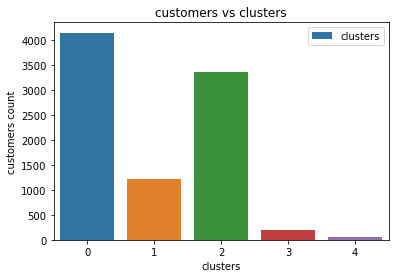

In [52]:
clusters = [val.prediction for val in data_customer.select('prediction').collect()]
customers_index = [i for i in range(data_customer.count())]
sns.countplot(clusters) # , customers_index)

plt.ylabel('customers count')
plt.xlabel('clusters')
plt.title('customers count vs clusters')
plt.legend(['clusters'], loc='upper right')

plt.show()

In [54]:
data_customer.columns

['CUST_ID',
 'BALANCE',
 'BALANCE_FREQUENCY',
 'PURCHASES',
 'ONEOFF_PURCHASES',
 'INSTALLMENTS_PURCHASES',
 'CASH_ADVANCE',
 'PURCHASES_FREQUENCY',
 'ONEOFF_PURCHASES_FREQUENCY',
 'PURCHASES_INSTALLMENTS_FREQUENCY',
 'CASH_ADVANCE_FREQUENCY',
 'CASH_ADVANCE_TRX',
 'PURCHASES_TRX',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE',
 'prediction']

/home/decentboy/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


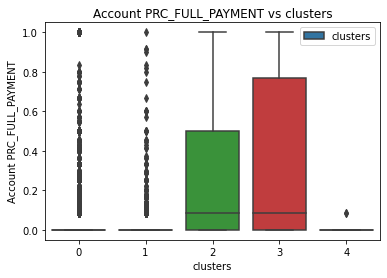

<AxesSubplot:ylabel='Count'>

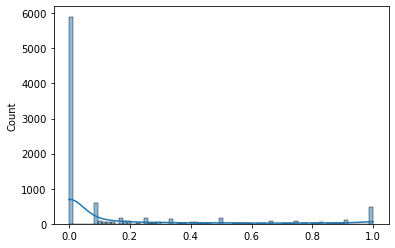

In [84]:
clusters = [val.prediction for val in data_customer.select('prediction').collect()]
PRC_FULL_PAYMENT = [val.PRC_FULL_PAYMENT for val in data_customer.select('PRC_FULL_PAYMENT').collect()]

sns.boxplot(clusters, PRC_FULL_PAYMENT)

plt.ylabel('Account PRC_FULL_PAYMENT')
plt.xlabel('clusters')
plt.title('Account PRC_FULL_PAYMENT vs clusters')
plt.legend(['clusters'], loc='upper right')

plt.show()

sns.histplot(PRC_FULL_PAYMENT, kde=True)

/home/decentboy/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


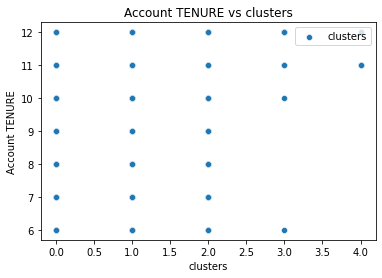

<AxesSubplot:ylabel='Count'>

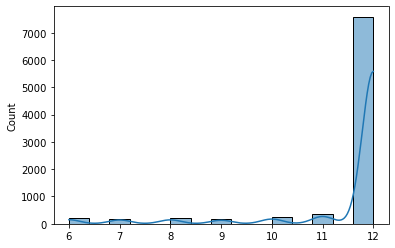

In [81]:
clusters = [val.prediction for val in data_customer.select('prediction').collect()]
TENURE = [val.TENURE for val in data_customer.select('TENURE').collect()]

sns.scatterplot(clusters, TENURE)

plt.ylabel('Account TENURE')
plt.xlabel('clusters')
plt.title('Account TENURE vs clusters')
plt.legend(['clusters'], loc='upper right')

plt.show()

sns.histplot(TENURE, kde=True)

/home/decentboy/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


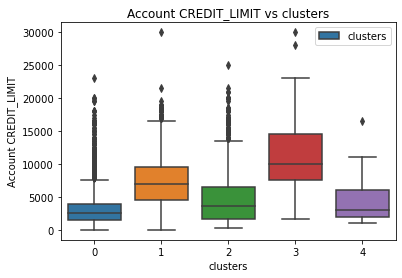

In [61]:
clusters = [val.prediction for val in data_customer.select('prediction').collect()]
CREDIT_LIMIT = [val.CREDIT_LIMIT for val in data_customer.select('CREDIT_LIMIT').collect()]

sns.boxplot(clusters, CREDIT_LIMIT)

plt.ylabel('Account CREDIT_LIMIT')
plt.xlabel('clusters')
plt.title('Account CREDIT_LIMIT vs clusters')
plt.legend(['clusters'], loc='upper right')

plt.show()

/home/decentboy/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


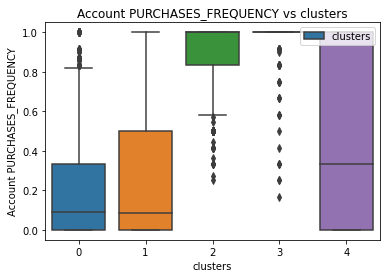

In [66]:
clusters = [val.prediction for val in data_customer.select('prediction').collect()]
PURCHASES_FREQUENCY = [val.PURCHASES_FREQUENCY for val in data_customer.select('PURCHASES_FREQUENCY').collect()]

sns.boxplot(clusters, PURCHASES_FREQUENCY)

plt.ylabel('Account PURCHASES_FREQUENCY')
plt.xlabel('clusters')
plt.title('Account PURCHASES_FREQUENCY vs clusters')
plt.legend(['clusters'], loc='upper right')

plt.show()

/home/decentboy/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


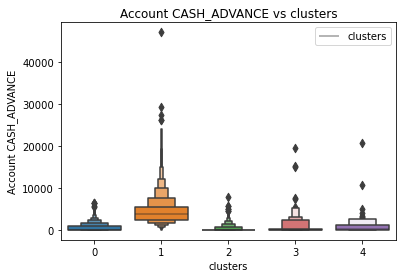

In [67]:
clusters = [val.prediction for val in data_customer.select('prediction').collect()]
CASH_ADVANCE = [val.CASH_ADVANCE for val in data_customer.select('CASH_ADVANCE').collect()]

sns.boxenplot(clusters, CASH_ADVANCE)

plt.ylabel('Account CASH_ADVANCE')
plt.xlabel('clusters')
plt.title('Account CASH_ADVANCE vs clusters')
plt.legend(['clusters'], loc='upper right')

plt.show()

/home/decentboy/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


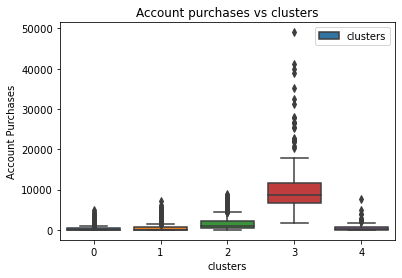

In [69]:
clusters = [val.prediction for val in data_customer.select('prediction').collect()]
PURCHASES = [val.PURCHASES for val in data_customer.select('PURCHASES').collect()]

sns.boxplot(clusters, PURCHASES)

plt.ylabel('Account Purchases')
plt.xlabel('clusters')
plt.title('Account purchases vs clusters')
plt.legend(['clusters'], loc='upper right')

plt.show()

/home/decentboy/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


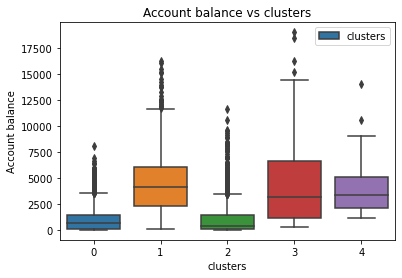

In [70]:
clusters = [val.prediction for val in data_customer.select('prediction').collect()]
BALANCE = [val.BALANCE for val in data_customer.select('BALANCE').collect()]

sns.boxplot(clusters, BALANCE)

plt.ylabel('Account balance')
plt.xlabel('clusters')
plt.title('Account balance vs clusters')
plt.legend(['clusters'], loc='upper right')

plt.show()

Why PySpark?

PySpark uses the concept of Data Parallelism or Result Parallelism when performing the K Means clustering. Imagine you need to roll out targeted marketing campaigns for the Boxing Day event in Melbourne and you want to reach out to 200K customers with different purchasing attributes. Imagine running multiple iterations of K Means on your local system. For K=5, the number of distance metrics you require to calculate is 5 x 200K = 1Million. 1 Million such metrics need to be calculated for say 30 times before a convergence criterion is met, i.e. 30Million distances (euclidean). You will require a lot of computation power and time to handle a scenario like this

Data Parallelism:

What data parallelism does is, creates parallelism from the beginning by partitioning the dataset into smaller partitions. On the other hand, result parallelism is based on targeted clusters. Let’s say:

D = Number of Records {X1, X2, ……, Xn}
k = Number of clusters
P = Number of Processors {P1, P2,…Pm}
C = Initial Centroids {C1, C2, …. Ck}

Data D is divided across P processors. Each processor works on a set of records (determined by spark configuration). The initial centroid values, C, are shared across each of these processors

Now every processor has centroid information. The processors compute the distance of their records to these centroids and form local clusters by assigning data points to its closest centroid

Once step 2 is done, the sum and count of records for each of these clusters across P processors are stored by a master process for future reference

Once one iteration is completed, the information from the processor is exchanged and a master process computes the updated Centroids and shares them across the P processors again, i.e. one point is allocated to K clusters, a master process updates the centroids, and reshare the information back with the processors

This process keeps iterating till convergence is met. Once a convergence criterion is met, the master process collects local clusters and combines them into a global one

Imagine 200K records divided across 3 processors each having ~70K records. This is where distributed processing comes into the picture to reduce the volume of data, yet ensuring a complete result.

Result Parallelism:
    
In result parallelism say:
    
D = Number of Records {X1, X2, ……, Xn}
k = Number of clusters
P = Number of Processors {P1, P2,…Pm}
C = Initial Centroids {C1, C2, …. Ck}

Data D is divided across P processors and then sorted within each processor. 

Each processor works on a set of records (determined by spark configuration)

The initial centroid values, C, are initialized and divided/shared across each of these processors (i.e., unlike data parallelism where all centroid values are shared across all processors, here, we pass one centroid value to one processor

Now every processor has one centroid of information. Compute the distance of these points to these centroids. For data points in a processor which are extremely low or high: If they are closer to the centroid of processor assign them to that cluster, else if they are closer to the centroid belonging to a different processor, move data point to the new processor

Repeat till convergence is met. All local clusters from Processor P is returned